## Warehouse optimization

Within this kernel we will analyse sales data of an UK online retailer. As storage area may be expensive and fast delivery on time is important to prevail over the competition we like to help the retailer by predicting daily amounts of sold products. 

## Table of contents

**Caution - Everything is heavily under construction ;-)** 

### [Get ready to take-off](#takeoff) 

1. [Prepare to start](#load) (complete)
2. [Get familiar with the data](#intro) (complete)
3. [Get an initial feeling for the data by exploration](#feeling) 
    * [Missing values](#missing) (complete)
    * [The time period](#timeperiod) (complete)
    * [The invoice number](#invoiceno) (complete)
    * [Stockcodes](#stockcodes) (complete)
    * [Descriptions](#descriptions) (complete)
    * [Customers](#customers)
    * [Countries](#countries) (complete)
    * [Unit Price](#unitprice)
    * [Quantities](#quantities) (complete)
    * [Revenues](#revenues)
    * [Conclusion](#expconclusion)
4. [Focus on daily product sales](#daily) 

# Get ready to take-off <a class="anchor" id="takeoff"></a>

## 1. Prepare to start <a class="anchor" id="load"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

In [2]:
print(listdir("../input"))

['glove-global-vectors-for-word-representation', 'ecommerce-data']


In [3]:
data = pd.read_csv("../input/ecommerce-data/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541909, 8)

The data has 541909 entries and 8 variables.

## 2. Get familiar with the data <a class="anchor" id="intro"></a>

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


We can see that the datafile has information given for **each single transaction**. Take a look at the InvoiceNo and the CustomerID of the first entries. Here we can see that **one customer with ID 17850 of the United Kingdom made a single order that has the InvoideNo 536365**. The customer ordered **several products with different stockcodes, descriptions, unit prices and quantities**. In addition we can see that the InvoiceDate was the same for these products. 

## 3. Get an initial feeling for the data by exploration <a class="anchor" id="feeling"></a>

### Missing values <a class="anchor" id="missing"></a>

How many % of missing values do we have for each feature?

In [5]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Almost 25 % of the customers are unknown! That's very strange. In addition we have 0.2 % of missing descriptions. This looks dirty. Let's gain a further impression by considering some examples.

**Missing descriptions**

In [6]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


How often do we miss the customer as well?

In [7]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

True    1454
Name: CustomerID, dtype: int64

And the unit price?

In [8]:
data[data.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

In **cases of missing descriptions we always miss the customer and the unit price as well**. Why does the retailer records such kind of entries without a further description? It seems that there is no sophisticated procedure how to deal with and record such kind of transactions. This is already a hint that **we could expect strange entries in our data and that it can be difficult to detect them**! 

**Missing Customer IDs**

In [9]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [10]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


That's bad as well. **The price and the quantities of entries without a customer ID can show extreme outliers**. As we might want to create features later on that are based on historical prices and sold quantities, this is very disruptive. Our first **advice for the retailer is to setup strategies for transactions that are somehow faulty or special**. And the question remains: Why is it possible for a transaction to be without a customer ID. Perhaps you can purchase as a quest but then it would of a good and clean style to plugin a special ID that indicates that this one is a guest. Ok, next one: Do we have hidden nan-values in Descriptions? To find it out, let's create a new feature that hold descriptions in lowercase:

**Hidden missing descriptions**

Can we find "nan"-Strings?

In [11]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

Can we find empty ""-strings?

In [12]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    540455
Name: lowercase_descriptions, dtype: int64

We found **additional, hidden nan-values that show a string "nan" instead of a nan-value**. Let's transform them to NaN: 

In [13]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

As we don't know why customers or descriptions are missing and we have seen strange outliers in quantities and prices as well as zero-prices, **let's play safe and drop all of these occurences**.

In [14]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

Just to be sure: Is there a missing value left?

In [15]:
data.isnull().sum().sum()

0

### The Time period <a class="anchor" id="timeperiod"></a>

How long is the period in days?

In [16]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [17]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


### The invoice number <a class="anchor" id="invoiceno"></a>

How many different invoice numbers do we have?

In [18]:
data.InvoiceNo.nunique()

22186

In the data description we can find that a cancelled transactions starts with a "C" in front of it. Let's create a feature to easily filter out these cases:

In [19]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

False    97.81007
True      2.18993
Name: IsCancelled, dtype: float64

2,2 % of all entries are cancellations.  

In [20]:
data.loc[data.IsCancelled==True].describe()

,Quantity,UnitPrice
count,8896.000000,8896.000000
mean,-30.882981,18.862815
std,1170.746458,444.590459
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


**All cancellations have negative quantites but positive, non-zero unit prices**. Given this data we are not easily able to understand why a customer made a return and it's very difficult to predict such cases as there could be several, hidden reasons why a cancellation was done. Let's drop them:

In [21]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

### Stockcodes <a class="anchor" id="stockcodes"></a>

How many unique stockcodes do we have?

In [22]:
data.StockCode.nunique()

3663

Which codes are most common?

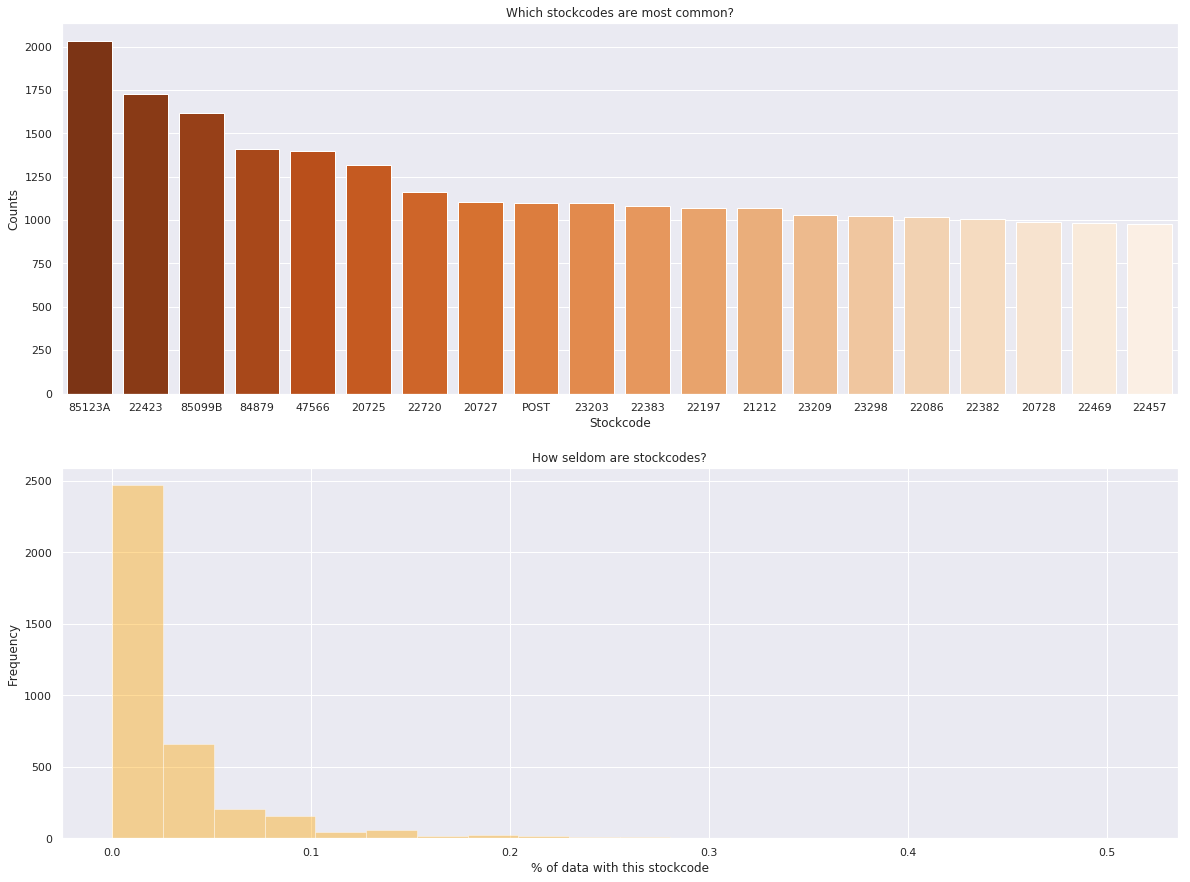

In [23]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

* Do you the the **POST** in the most common stockcode counts?! **That's a strange one!** Hence we could expect strange occurences not only in the descriptions and customerIDs but also in the stockcode. OHOHOH! It's code is shorter than the others as well as not numeric. 
* Most stockcodes are very seldom. This indicates that the **retailer sells many different products** and that there is no strong secialization of a specific stockcode. Nevertheless we have to be careful as this must not mean that the retailer is not specialized given a specific product type. The stockcode could be a very detailed indicator that does not yield information of the type, for example water bottles may have very different variants in color, name and shapes but they are all water bottles.  

Let's count the number of numeric chars in and the length of the stockcode:

In [24]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

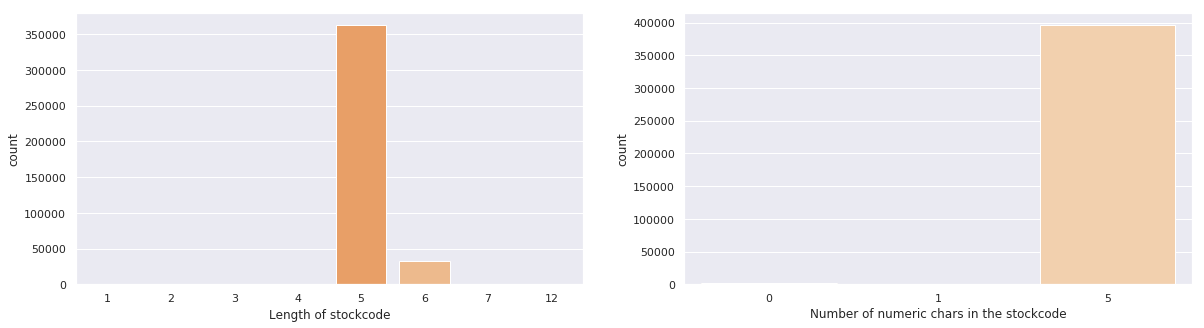

In [25]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data["StockCodeLength"], palette="Oranges_r", ax=ax[0])
sns.countplot(data["nNumericStockCode"], palette="Oranges_r", ax=ax[1])
ax[0].set_xlabel("Length of stockcode")
ax[1].set_xlabel("Number of numeric chars in the stockcode");

Even though the majority of samples has a stockcode that consists of 5 numeric chars, we can see that there are other occurences as well. The length can vary between 1 and 12 and there are stockcodes with no numeric chars at all!

In [26]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

Ihh, again something that we don't want to predict. Again this indicates that the retailer does not speparate well between special kind of transactions and valid customer-retailer transactions. Let's drop all of these occurences:

In [27]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()

2783

In [28]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

### Descriptions <a class="anchor" id="descriptions"></a>

How many unique descriptions do we have?

In [29]:
data.Description.nunique()

2983

And which are most common?

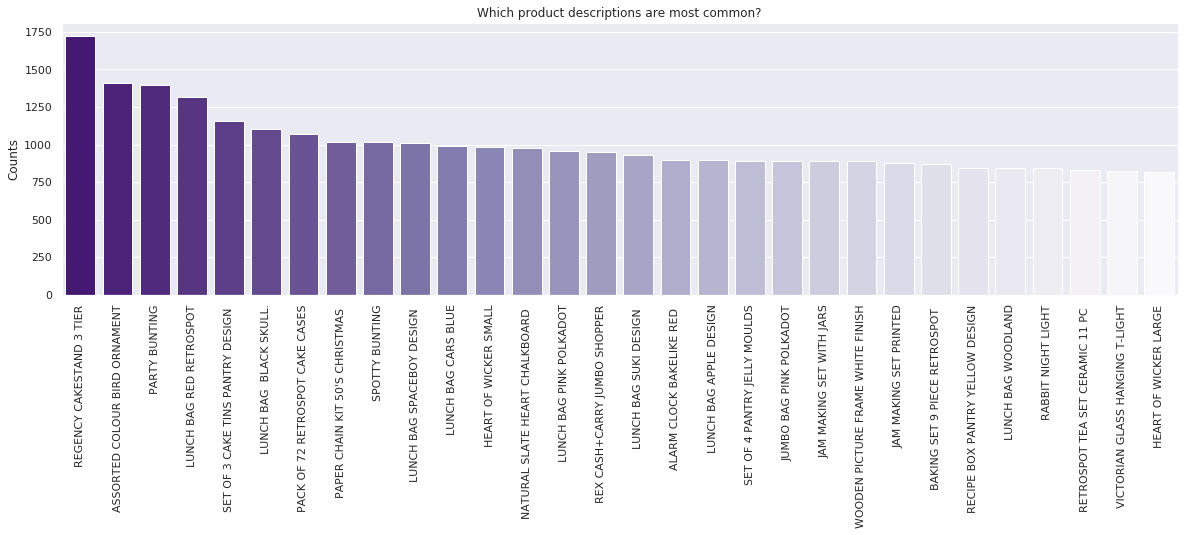

In [30]:
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

Ok, we can see that **some descriptions correspond to a similar product type**. Do you see the multiple occurences of lunch bags? We often have **color information about the product** as well. Furthermore the most common descriptions seem to confirm that **the retailer sells various different kinds of products**. All descriptions seem to consist of **uppercase chars**. Ok, now let's do some addtional analysis on the descriptions by counting the length and the number of lowercase chars. 

In [31]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [32]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

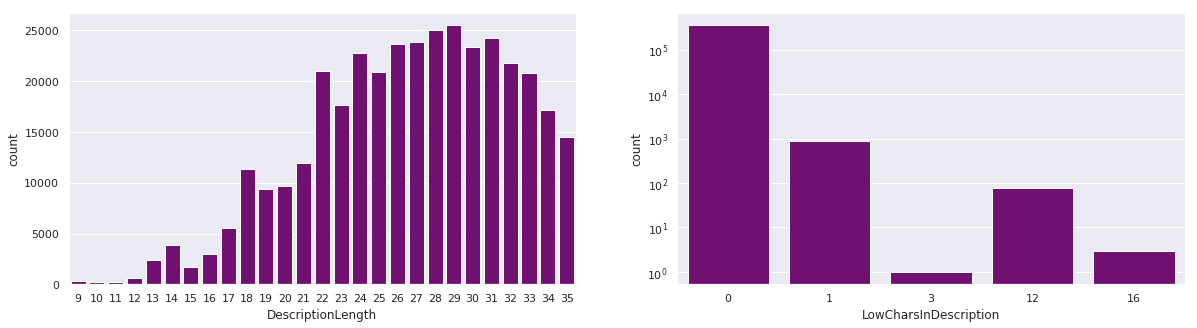

In [33]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(data.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

Oh, great! **Almost all descriptions do not have a lowercase chars, but we have found exceptional cases!**

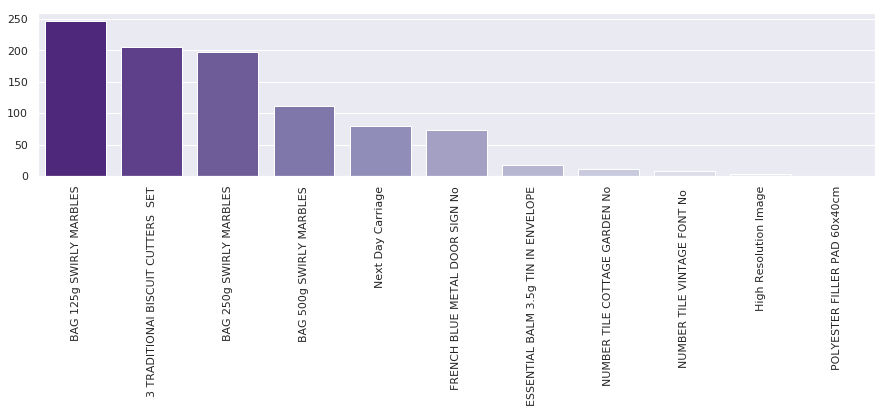

In [34]:
lowchar_counts = data.loc[data.LowCharsInDescription > 0].Description.value_counts()

plt.figure(figsize=(15,3))
sns.barplot(lowchar_counts.index, lowchar_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

**Next day carriage and high resolution image are strange!** Let's compute the fraction of lower with respect to uppercase letters:

In [35]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [36]:
data.UpCharsInDescription.describe()

count    362522.000000
mean         22.572291
std           4.354845
min           3.000000
25%          20.000000
50%          23.000000
75%          26.000000
max          32.000000
Name: UpCharsInDescription, dtype: float64

In [37]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

Next Day Carriage        79
High Resolution Image     3
Name: Description, dtype: int64

It's strange that they differ from the others. Let's drop them:

In [38]:
data = data.loc[data.UpCharsInDescription > 5].copy()

And what about the descriptions with a length below 14?

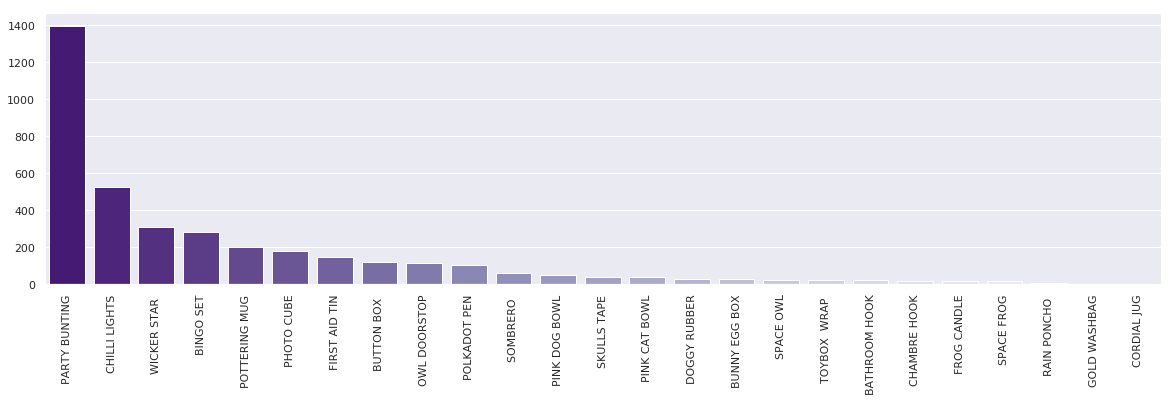

In [39]:
dlength_counts = data.loc[data.DescriptionLength < 14].Description.value_counts()

plt.figure(figsize=(20,5))
sns.barplot(dlength_counts.index, dlength_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

Ok, descriptions with small length look valid and we should not drop them. Ok, now let's see how many unique stock codes do we have and how many unique descriptions?

In [40]:
data.StockCode.nunique()

2781

In [41]:
data.Description.nunique()

2981

We still have more descriptions than stockcodes and we should continue to find out why they differ.

In [42]:
data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23196    4
23236    4
23244    3
23231    3
23131    3
22937    3
23126    3
23370    3
23366    3
23413    3
Name: Description, dtype: int64

Wow, we still have stockcodes with multiple descriptions. Let's look at an example:

In [43]:
data.loc[data.StockCode == "23244"].Description.value_counts()

ROUND STORAGE TIN VINTAGE LEAF    96
STORAGE TIN VINTAGE LEAF           7
CANNISTER VINTAGE LEAF DESIGN      2
Name: Description, dtype: int64

Ok, browsing through the cases we can see that stockcodes are sometimes named a bit differently due to missing or changed words or typing errors. None the less they look ok and we can continue.

### Customers <a class="anchor" id="customers"></a>

In [44]:
data.CustomerID.nunique()

4315

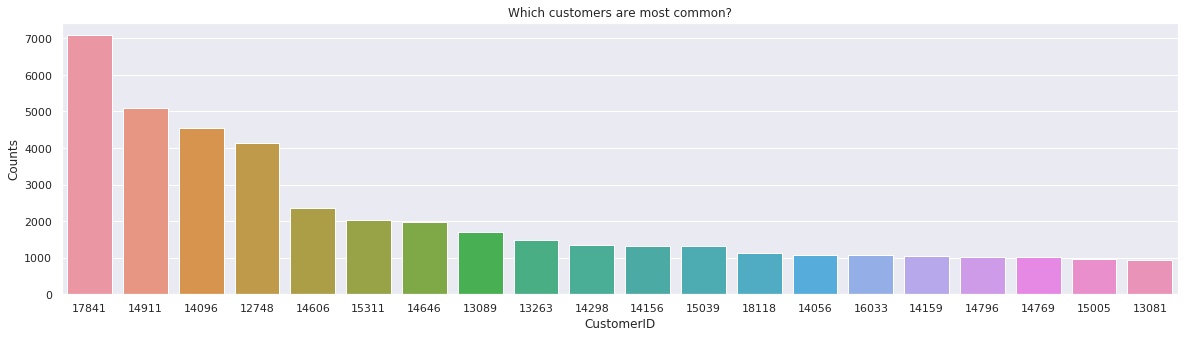

In [45]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

### Countries <a class="anchor" id="countries"></a>

How many unique countries are delivered by the retailer?

In [46]:
data.Country.nunique()

37

And which ones are most common?

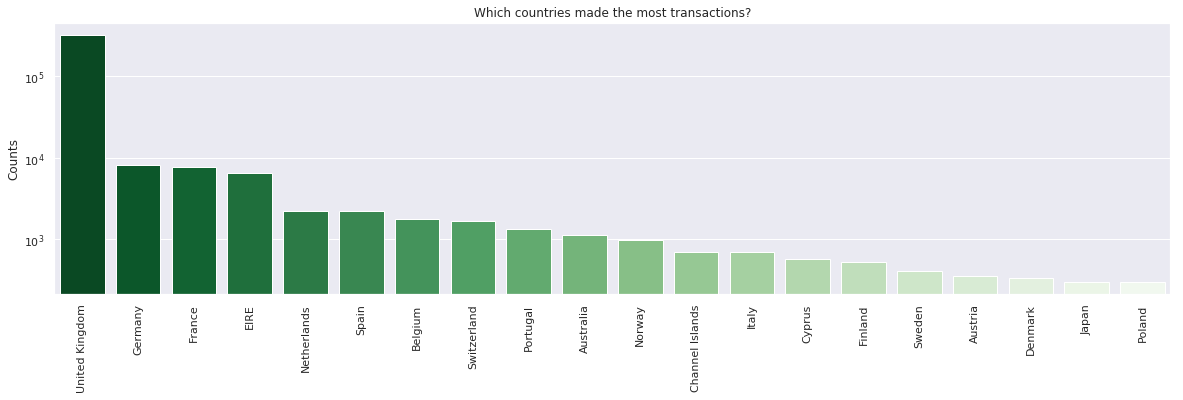

In [47]:
country_counts = data.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

We can see that the retailer sells almost all products in the UK, followed by many european countries. How many percentage of entries are inside UK?

In [48]:
data.loc[data.Country=="United Kingdom"].shape[0] / data.shape[0] * 100

89.10192031784572

Let's create a feature to indicate inside or outside of the UK:

In [49]:
data["UK"] = np.where(data.Country == "United Kingdom", 1, 0)

### Unit Price <a class="anchor" id="unitprice"></a>

In [50]:
data.UnitPrice.describe()

count    362440.000000
mean          2.885355
std           4.361812
min           0.000000
25%           1.250000
50%           1.790000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

Again, we have strange occurences: zero unit prices!

In [51]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription,UK
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom,asstd design 3d paper stickers,30,0,25,1
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE,set of 6 nativity magnets,26,0,20,0
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia,biscuit tin vintage christmas,29,0,26,0
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands,set of 2 ceramic christmas reindeer,35,0,29,0
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646,Netherlands,polkadot rain hat,18,0,15,0


That's not good again. It's not obvious if they are gifts to customers or not :-( Let's drop them:

In [52]:
data = data.loc[data.UnitPrice > 0].copy()

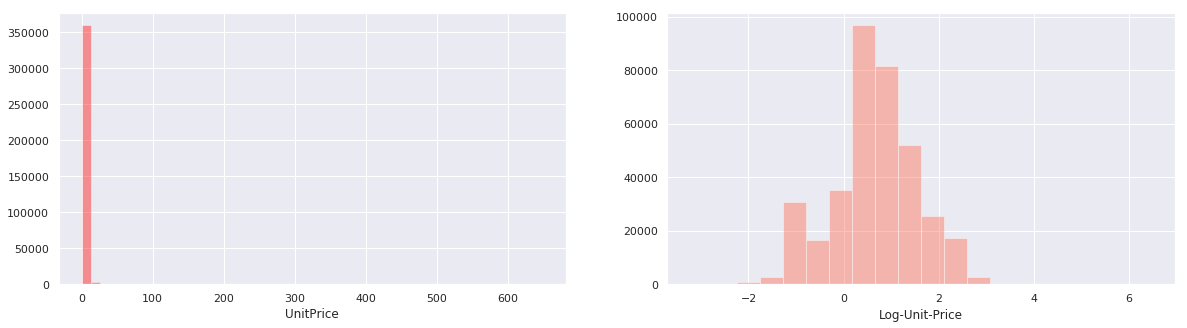

In [53]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.UnitPrice, ax=ax[0], kde=False, color="red")
sns.distplot(np.log(data.UnitPrice), ax=ax[1], bins=20, color="tomato", kde=False)
ax[1].set_xlabel("Log-Unit-Price");

In [54]:
np.exp(-2)

0.1353352832366127

In [55]:
np.exp(3)

20.085536923187668

In [56]:
np.quantile(data.UnitPrice, 0.95)

8.5

Let's focus transactions with prices that fall into this range as we don't want to make predictions for very seldom products with high prices. Starting easy is always good!

In [57]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()

### Quantities <a class="anchor" id="quantities"></a>

Ok, the most important one - the target. Let's take a look at its distribution:

In [58]:
data.Quantity.describe()

count    361608.000000
mean         13.024112
std         187.566510
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Ok, most products are sold in quantities from 1 to 12. But, we have extreme, unrealistic outliers again:

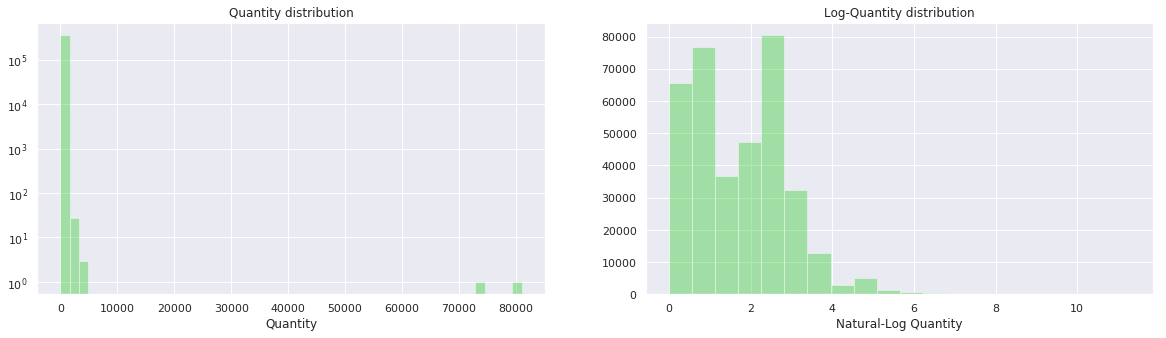

In [59]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

As you can see by the log-transformed distribution it would make sense to make a cut at:

In [60]:
np.exp(4)

54.598150033144236

In [61]:
np.quantile(data.Quantity, 0.95)

36.0

In this case we would still cover more than 95 % of the data!

In [62]:
data = data.loc[data.Quantity < 55].copy()

### Revenues <a class="anchor" id="revenues"></a>

### Conclusion <a class="anchor" id="expconclusion"></a>

## Focus on daily product sales <a class="anchor" id="daily"></a>

As we like to predict the daily amount of product sales, we need to compute a daily aggregation of this data. For this purpose we need to extract temporal features out of the InvoiceDate. In addition we can compute the revenue gained by a transaction using the unit price and the quantity:

In [63]:
data["Revenue"] = data.Quantity * data.UnitPrice

data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

As the key task of this kernel is to predict the amount of products sold per day, we can sum up the daily quantities per product stockcode :

In [64]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

This way we loose information abount customers, countries and price information but we will recover it later on during this kernel. Besides the quantities let's aggregate the revenues as well:

In [65]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


#### How are the quantities and revenues distributed?

In [66]:
daily_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,195853.000000,195853.000000
mean,14.964244,28.181114
std,18.809496,43.938183
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.600000
max,411.000000,1266.300000


As we can see by the min and max values the **target variable shows extreme outliers**.  If we would like to use it as targets, we **should exclude them as they will mislead our validation. As I like to use early stopping this will directly influence training of predictive models as well**.  

In [67]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 88.48000000001048)


In [68]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.78, 204.0)


Let's **only use target ranges data that are occupied by  90 % of the data entries**. This is a first and easy strategy to exclude heavy outliers but we should always be aware of the fact that we have lost some information given by the remaining % we have excluded. It could be nice and useful in general to understand and analyse what has caused these outliers. 

In [69]:
samples = daily_data.shape[0]

In [70]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

How much entries have we lost?

In [71]:
samples - daily_data.shape[0]

5258

Let's take a look at the remaining distributions of daily quantities:

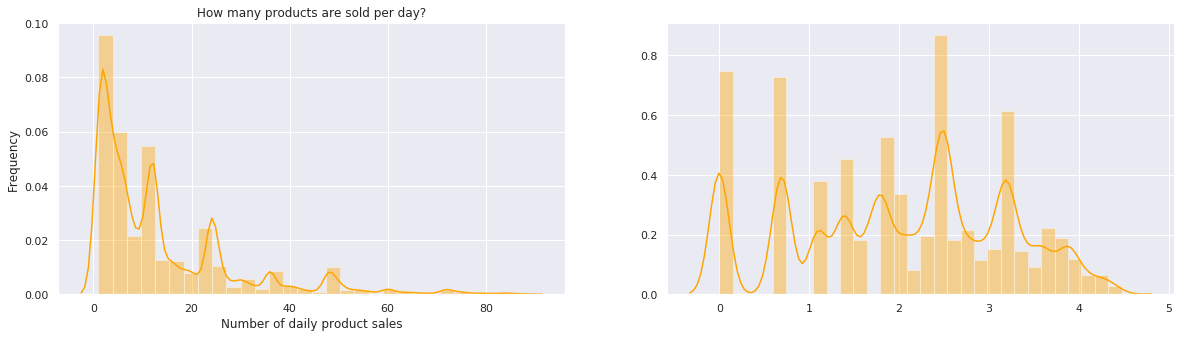

In [72]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

We can see that the distributions are **right skewed. Lower values are more common**. In addition the daily sales quantities seem to be **multimodal**. A daily sale of 1 is common as well as a quantity of 12 and 24. This pattern is very interesting and leads to the conclusion that quantities are often divisible by 2 or 3. In a nutshell we can say that specific products are often bought as single quantites or in a small bunch.

## How to predict daily product sales? <a class="anchor" id="model"></a>

In this kernel I like to use [catboost ](https://catboost.ai/) as predictive model. The prediction of daily quantities and revenues are both regression tasks and consequently I will use the catboost regressor. The loss and metric I like to use is the [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE):

$$ E = \sqrt{ \frac{1}{N}\sum_{n=1}^{N} (t_{n} - y_{n})^{2}}$$

It computes the error between the target value $t_{n}$ and the predicted value $y_{n}$ per sample, takes the square to make sure that both, positive and negative deviations, contribute to the sum the same way. Then the mean is taken by dividing with the total amount $N$ of samples (entries) in the data. And finally to obtain an impression of the error for single predictions, the root is taken. What should we keep in mind when working with this loss and metric function? :-) It's heavily influenced by outliers! **If we have some predictions that are far away from the targets, they will guide the mean towards higher values as well. Hence it could be that we will make nice predictions for a majority of samples but the RMSE is still high due to high errors for a minority of samples**. 

### Validation strategy

As the **data covers only one year and we have a high increase of sold products during pre-christmas period**, we need to select validation data carefully. I will start with validation data that covers at least 8 full weeks (+ remaining days). After generating new features by exploring the data, I will use a sliding window time series validation that should help us to understand if the model is able to solve the prediction task during both times: pre-christmas season and non-christmas season. 

### Catboost family and hyperparameter class <a class="anchor" id="classes"></a>

To easily generate new models and compare results between them I wrote some classes:

**Hyperparameter Class**

This class holds all important hyperparameters we have to set before training like the loss function, the evaluation metric, the max depth of trees, the number of max number of trees (iterations) and the l2_leaf_reg for regularization to avoid overfitting. 

In [73]:
class CatHyperparameter:
    
    def __init__(self,
                 loss="RMSE",
                 metric="RMSE",
                 iterations=1000,
                 max_depth=4,
                 l2_leaf_reg=3,
                 #learning_rate=0.5,
                 seed=0):
        self.loss = loss,
        self.metric = metric,
        self.max_depth = max_depth,
        self.l2_leaf_reg = l2_leaf_reg,
        #self.learning_rate = learning_rate,
        self.iterations=iterations
        self.seed = seed

**Catmodel class**

This model obtains a train & validation pool as data or pandas dataframes for features X and targets y together with a week. It's the first week of our validation data and all other weeks above are used as well. It trains the model and can show learning process as well as feature importances and some figures for result analysis. It's the fastest choice you can make for playing around.

In [74]:
class Catmodel:
    
    def __init__(self, name, params):
        self.name = name
        self.params = params
    
    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool
    
    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != np.float)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(self.x_val, self.y_val, cat_features=cat_features_idx)
    
    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )
    
    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot);
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))
    
    def score(self):
        return self.model.score(self.val_pool)
    
    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)
    
    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))
    
    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax
    
    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))
        
    def predict(self, x):
        return self.model.predict(x)
    
    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )
    
    

**Hyperparameter-Search class**

This is a class for hyperparameter search that uses Bayesian Optimization and Gaussian Process Regression to find optimal hyperparameters. I decided to use this method as the computation of the score for one catfamily model may be expensive. In this case bayesian optimization could be a plus. As this optimization methods takes some time as well you should try random search as well as this may be faster. 

In [75]:
import GPyOpt

class Hypertuner:
    
    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None
    
    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()
    
    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.X[np.argmin(optimizer.Y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))
    
    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model

**Time series validation Catfamily**

This model holds the information about how to split the data into validation chunks and it organizes the training with sliding window validation. Furthermore it can return a score as the mean over all RMSE scores of its models. 

In [76]:
class CatFamily:
    
    def __init__(self, params, X, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(X.dtypes != np.float)[0]
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params
    
    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.X)
    
    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.X[train_idx], self.X[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool
    
    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)
    
    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score
    
    def score(self):
        return np.mean(self.model_scores)
    
    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, X, plot_type="bar")

### Baseline model & result analysis  <a class="anchor" id="baseline"></a>

Let's see how good this model performs without feature engineering and hyperparameter search:

In [77]:
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [78]:
week = daily_data.Week.max() - 2
print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    daily_data[daily_data.Week==week].Date.min()
))

Validation after week 49
Validation starts at timepoint 2010-12-06 00:00:00


In [79]:
X = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1)
daily_data.Quantity = np.log(daily_data.Quantity)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("baseline", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

baseline, early-stopped model tree count 699


If you have forked this kernel and are in interactive model you can see that the model loss has converged. How big is the evaluated root mean square error on validation data?

In [80]:
model.score()

1.065775039230805

This value is high, but as already mentioned the RSME is influenced by outliers and we should take a look at the distribution of individual absolute errors:

Median absolute error: 0.7523879147418431


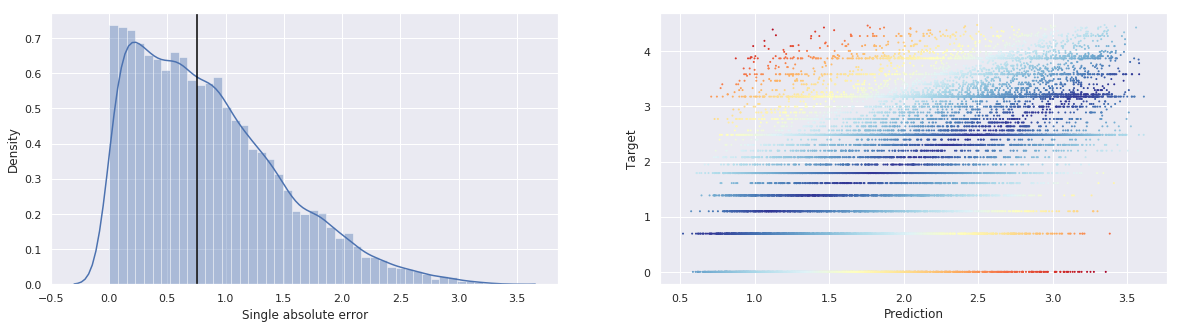

In [81]:
model.show_val_results();

* We can see that the **distribution of absolute errors of single predictions is right skewed.** 
* The **median single error (black) is half of the RMSE score and significantly lower**. 
* By plotting the target versus prediction we can see that we **made higher errors for validation entries that have high true quantity values above 30**. The strong blue line shows the identity where predictions are close to target values. **To improve we need to make better predictions for products with true high quantities during validation time**. 

The model has complex ctrs, so the SHAP values will be calculated approximately.


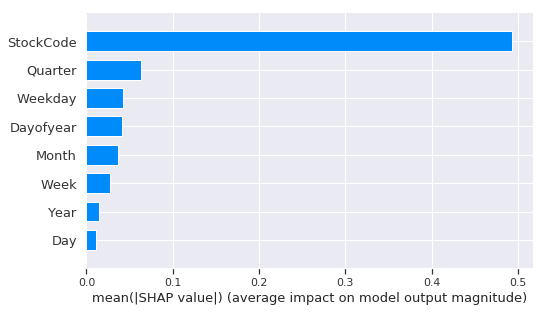

In [82]:
model.show_importances()

* We can see that the **stock code as well as the description of the products are very important**. They do not have a color as they are not numerical and do not have low or high values. 
* The **weekday** is an important feature as well. We have already seen this by exploring the data. Low values from monday up to thursday are those days where the retailer sales most products. In contrast high values (friday to sunday) only yield a few sales. 

The model has complex ctrs, so the SHAP values will be calculated approximately.


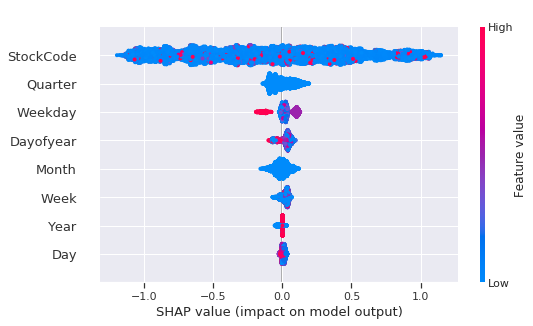

In [83]:
model.show_importances(kind=None)

* Take a look at the **weekday to understand this plot**: Low values (0 to 3) correspond to Monday, Tuesday, Wednesday and Thursday. These are days with high amount of product sales (high quantity target values). They are colored in blue and **push towards higher sharp values and consequently to higher predicted quantity values**. Higher weekday values suite to friday, saturday and sunday. They are colored in red and **push towards negative sharp values and to lower predicted values**. This confirms to the observations we made during exploration of weekday and the sum of daily quantities.    
* The **StockCode and the Description** are important features but they are also **very complex**. We have seen that we have close to 4000 different stock codes and even more descriptions. To improve we should **try to engineer features that are able to descripe the products in a more general way**. 

In [84]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

9.383558683392673

In [85]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

4.875429653223724

### Bayesian Hyperparameter Search with GPyOpt <a class="anchor" id="hypersearch"></a>

Ok, now we have gained some feeling for a single model. Let's find out if we can obtain a better score after hyperparameter search:

In [86]:
#search = Hypertuner(model, max_depth=5, max_l2_leaf_reg=30)
#search.learn()
#model = search.retrain_catmodel()
#print(model.score())
#model.show_importances(kind=None)

## Feature engineering

### Creating product types

In [87]:
products = pd.DataFrame(index=data.loc[data.Week < week].StockCode.unique(), columns = ["MedianPrice"])

products["MedianPrice"] = data.loc[data.Week < week].groupby("StockCode").UnitPrice.median()
products["MedianQuantities"] = data.loc[data.Week < week].groupby("StockCode").Quantity.median()
products["Customers"] = data.loc[data.Week < week].groupby("StockCode").CustomerID.nunique()
products["DescriptionLength"] = data.loc[data.Week < week].groupby("StockCode").DescriptionLength.median()
#products["StockCode"] = products.index.values
org_cols = np.copy(products.columns.values)
products.head()

,MedianPrice,MedianQuantities,Customers,DescriptionLength
71053,3.75,4.0,137,19
22752,8.50,2.0,163,28
21730,4.95,3.0,64,33
22633,2.10,4.0,263,22
22632,2.10,4.0,227,25


In [88]:
for col in org_cols:
    if col != "StockCode":
        products[col] = boxcox(products[col])[0]

Text(0,0.5,'Boxcox-Median-Quantities')

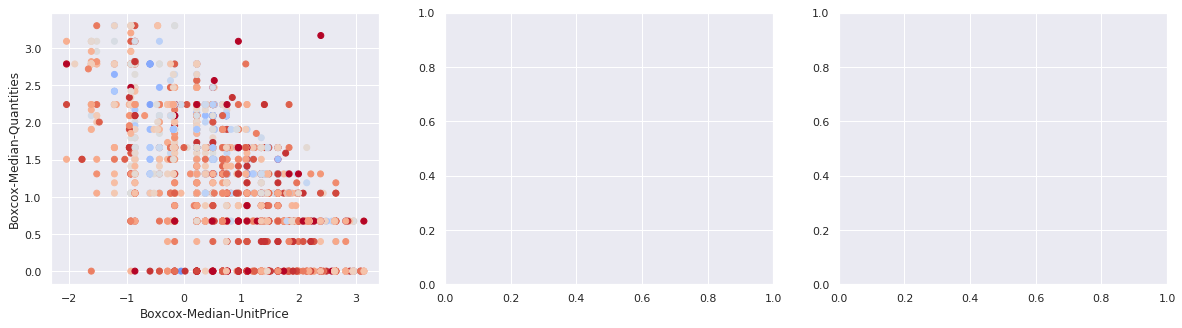

In [89]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(products.MedianPrice.values, products.MedianQuantities.values,
           c=products.Customers.values, cmap="coolwarm_r")
ax[0].set_xlabel("Boxcox-Median-UnitPrice")
ax[0].set_ylabel("Boxcox-Median-Quantities")

In [90]:
X = products.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [91]:
km = KMeans(n_clusters=30)
products["cluster"] = km.fit_predict(X)

daily_data["ProductType"] = daily_data.StockCode.map(products.cluster)
daily_data.ProductType = daily_data.ProductType.astype("object")
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue,ProductType
0,2010-12-01,2010,4,12,48,2,335,1,10002,4.094345,51.00,9
1,2010-12-01,2010,4,12,48,2,335,1,10125,0.693147,1.70,9
2,2010-12-01,2010,4,12,48,2,335,1,10133,1.609438,4.25,14
3,2010-12-01,2010,4,12,48,2,335,1,16014,2.302585,4.20,23
4,2010-12-01,2010,4,12,48,2,335,1,16016,2.302585,8.50,9


## Baseline for product types

In [92]:
daily_data["KnownStockCodeUnitPriceMedian"] = daily_data.StockCode.map(
    data.groupby("StockCode").UnitPrice.median())

known_price_iqr = data.groupby("StockCode").UnitPrice.quantile(0.75) 
known_price_iqr -= data.groupby("StockCode").UnitPrice.quantile(0.25) 
daily_data["KnownStockCodeUnitPriceIQR"] = daily_data.StockCode.map(known_price_iqr)

In [93]:
to_group = ["StockCode", "Year", "Month", "Week", "Weekday"]

daily_data = daily_data.set_index(to_group)
daily_data["KnownStockCodePrice_WW_median"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.median())
daily_data["KnownStockCodePrice_WW_mean"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2)))
daily_data["KnownStockCodePrice_WW_std"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.std().apply(lambda l: np.round(l, 2)))

daily_data = daily_data.reset_index()

In [94]:
daily_data.head()

,StockCode,Year,Month,Week,Weekday,Date,Quarter,Dayofyear,Day,Quantity,Revenue,ProductType,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std
0,10002,2010,12,48,2,2010-12-01,4,335,1,4.094345,51.00,9,0.85,0.0000,0.85,0.85,0.0
1,10125,2010,12,48,2,2010-12-01,4,335,1,0.693147,1.70,9,0.85,0.0000,0.85,0.85,NaN
2,10133,2010,12,48,2,2010-12-01,4,335,1,1.609438,4.25,14,0.42,0.3225,0.85,0.85,NaN
3,16014,2010,12,48,2,2010-12-01,4,335,1,2.302585,4.20,23,0.42,0.0000,0.42,0.42,NaN
4,16016,2010,12,48,2,2010-12-01,4,335,1,2.302585,8.50,9,0.85,0.0000,0.85,0.85,NaN


### Temporal patterns

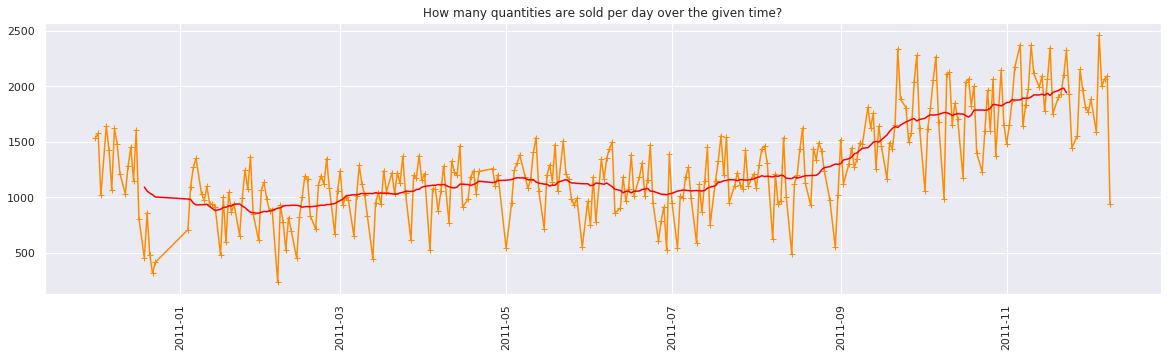

In [95]:
plt.figure(figsize=(20,5))
plt.plot(daily_data.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("How many quantities are sold per day over the given time?");

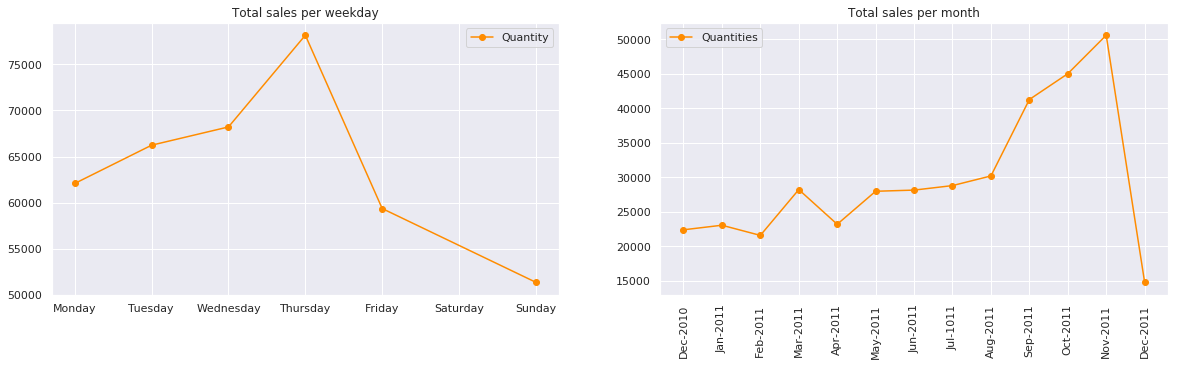

In [96]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

Both visualisations yield further interesting insights:

* **Thursday** seems to be the day on which most products are sold. 
* In contrast **friday, and sunday** have very **low transactions** 
* On **saturday** there are **no transactions** at all
* The **pre-Christmas season** starts in **september and shows a peak in november**
* Indeed **february and april are month with very low sales**. 

Let's create some new features for our daily aggregation that may be helpful to make better predictions:

In [97]:
daily_data["PreChristmas"] = (daily_data.Dayofyear <= 358) & (daily_data.Dayofyear >= 243) 

In [98]:
for col in ["Weekday", "Month", "Quarter"]:
    daily_data = daily_data.set_index(col)
    daily_data[col+"Quantity_mean"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.mean()
    daily_data[col+"Quantity_median"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.median()
    daily_data[col+"Quantity_mean_median_diff"] = daily_data[col+"Quantity_mean"] - daily_data[col+"Quantity_median"]
    daily_data[col+"Quantity_IQR"] = daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.75) - daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.25)
    daily_data = daily_data.reset_index()
daily_data.head()

,Quarter,Month,Weekday,StockCode,Year,Week,Date,Dayofyear,Day,Quantity,Revenue,ProductType,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std,PreChristmas,WeekdayQuantity_mean,WeekdayQuantity_median,WeekdayQuantity_mean_median_diff,WeekdayQuantity_IQR,MonthQuantity_mean,MonthQuantity_median,MonthQuantity_mean_median_diff,MonthQuantity_IQR,QuarterQuantity_mean,QuarterQuantity_median,QuarterQuantity_mean_median_diff,QuarterQuantity_IQR
0,4,12,2,10002,2010,48,2010-12-01,335,1,4.094345,51.00,9,0.85,0.0000,0.85,0.85,0.0,True,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
1,4,12,2,10125,2010,48,2010-12-01,335,1,0.693147,1.70,9,0.85,0.0000,0.85,0.85,NaN,True,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
2,4,12,2,10133,2010,48,2010-12-01,335,1,1.609438,4.25,14,0.42,0.3225,0.85,0.85,NaN,True,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
3,4,12,2,16014,2010,48,2010-12-01,335,1,2.302585,4.20,23,0.42,0.0000,0.42,0.42,NaN,True,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
4,4,12,2,16016,2010,48,2010-12-01,335,1,2.302585,8.50,9,0.85,0.0000,0.85,0.85,NaN,True,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712


In [99]:
to_group = ["StockCode", "PreChristmas"]
daily_data = daily_data.set_index(to_group)
daily_data["PreChristmasMeanQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.mean().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasMedianQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.median().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasStdQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.std().apply(lambda l: np.round(l, 1))
daily_data = daily_data.reset_index()

**Lag-Features:**

In [100]:
for delta in range(1,4):
    to_group = ["Week","Weekday","ProductType"]
    daily_data = daily_data.set_index(to_group)
        
    daily_data["QuantityProducttypeWeekWeekdayLag_" + str(delta) + "_median"] = daily_data.groupby(
        to_group).Quantity.median().apply(lambda l: np.round(l,1)).shift(delta)
    
    daily_data = daily_data.reset_index()
    daily_data.loc[daily_data.Week >= (week+delta),
                   "QuantityProductTypeWeekWeekdayLag_" + str(delta) + "_median"] = np.nan
    

In [101]:
data["ProductType"] = data.StockCode.map(products.cluster)

In [102]:
daily_data["TransactionsPerProductType"] = daily_data.ProductType.map(data.loc[data.Week < week].groupby("ProductType").InvoiceNo.nunique())

### About countries and customers



In [103]:
delta = 1
to_group = ["Week", "Weekday", "ProductType"]
daily_data = daily_data.set_index(to_group)
daily_data["DummyWeekWeekdayAttraction"] = data.groupby(to_group).CustomerID.nunique()
daily_data["DummyWeekWeekdayMeanUnitPrice"] = data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2))

daily_data["WeekWeekdayAttraction_Lag1"] = daily_data["DummyWeekWeekdayAttraction"].shift(1)
daily_data["WeekWeekdayMeanUnitPrice_Lag1"] = daily_data["DummyWeekWeekdayMeanUnitPrice"].shift(1)

daily_data = daily_data.reset_index()
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayAttraction_Lag1"] = np.nan
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayMeanUnitPrice_Lag1"] = np.nan
daily_data = daily_data.drop(["DummyWeekWeekdayAttraction", "DummyWeekWeekdayMeanUnitPrice"], axis=1)

In [104]:
daily_data["TransactionsPerStockCode"] = daily_data.StockCode.map(
    data.loc[data.Week < week].groupby("StockCode").InvoiceNo.nunique())

In [105]:
daily_data.head()

,Week,Weekday,ProductType,StockCode,PreChristmas,Quarter,Month,Year,Date,Dayofyear,Day,Quantity,Revenue,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std,WeekdayQuantity_mean,WeekdayQuantity_median,WeekdayQuantity_mean_median_diff,WeekdayQuantity_IQR,MonthQuantity_mean,MonthQuantity_median,MonthQuantity_mean_median_diff,MonthQuantity_IQR,QuarterQuantity_mean,QuarterQuantity_median,QuarterQuantity_mean_median_diff,QuarterQuantity_IQR,PreChristmasMeanQuantity,PreChristmasMedianQuantity,PreChristmasStdQuantity,QuantityProducttypeWeekWeekdayLag_1_median,QuantityProductTypeWeekWeekdayLag_1_median,QuantityProducttypeWeekWeekdayLag_2_median,QuantityProductTypeWeekWeekdayLag_2_median,QuantityProducttypeWeekWeekdayLag_3_median,QuantityProductTypeWeekWeekdayLag_3_median,TransactionsPerProductType,WeekWeekdayAttraction_Lag1,WeekWeekdayMeanUnitPrice_Lag1,TransactionsPerStockCode
0,48,2,9.0,10002,True,4,12,2010,2010-12-01,335,1,4.094345,51.00,0.85,0.0000,0.85,0.85,0.0,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712,1.4,0.0,2.4,0.7,NaN,1.9,NaN,0.7,NaN,4051.0,NaN,NaN,33.0
1,48,2,9.0,10125,True,4,12,2010,2010-12-01,335,1,0.693147,1.70,0.85,0.0000,0.85,0.85,NaN,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712,2.1,1.9,1.1,0.7,NaN,1.9,NaN,0.7,NaN,4051.0,46.0,1.08,50.0
2,48,2,14.0,10133,True,4,12,2010,2010-12-01,335,1,1.609438,4.25,0.42,0.3225,0.85,0.85,NaN,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712,2.5,2.6,0.6,0.7,NaN,0.7,NaN,3.2,NaN,4174.0,46.0,1.08,107.0
3,48,2,23.0,16014,True,4,12,2010,2010-12-01,335,1,2.302585,4.20,0.42,0.0000,0.42,0.42,NaN,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712,2.4,2.3,0.6,0.7,NaN,1.4,NaN,0.7,NaN,492.0,51.0,0.52,38.0
4,48,2,9.0,16016,True,4,12,2010,2010-12-01,335,1,2.302585,8.50,0.85,0.0000,0.85,0.85,NaN,2.062135,2.302585,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712,2.5,2.3,0.5,0.7,NaN,1.9,NaN,0.7,NaN,4051.0,5.0,0.49,53.0


In [106]:
daily_data["CustomersPerWeekday"] = daily_data.Month.map(
    data.loc[data.Week < week].groupby("Weekday").CustomerID.nunique())

In [107]:
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("new_features_1", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

new_features_1, early-stopped model tree count 989


In [108]:
model.score()

0.8786625408873414

The model has complex ctrs, so the SHAP values will be calculated approximately.


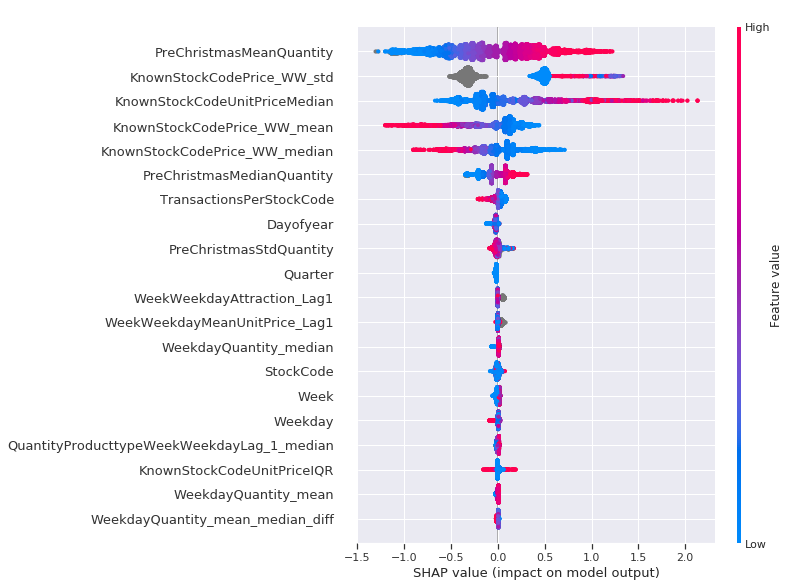

In [109]:
model.show_importances(kind=None)

Median absolute error: 0.5811811664930964


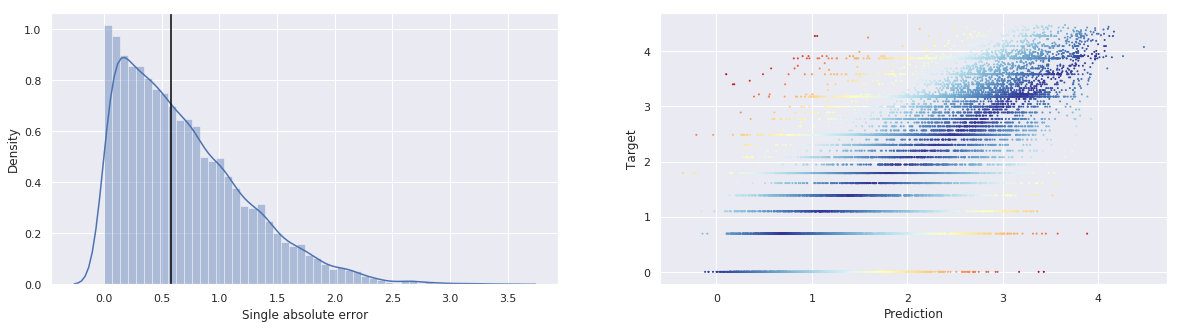

In [110]:
model.show_val_results();

In [111]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

7.556297861692108

In [112]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

3.911660064532171

In [113]:
search = Hypertuner(model)
#search.learn()

In [114]:
#model = search.retrain_catmodel()
#print(model.score())

In [115]:
#model.show_importances(kind=None)